In [ ]:
# based on https://colindcarroll.com/2019/08/18/very-parallel-mcmc-sampling/

In [122]:
import matplotlib.pyplot as plt

In [123]:
import numpy as np

In [124]:
import scipy.stats as st

In [125]:
dim = 2
cov = 0.1 * np.eye(dim) + 0.9 * np.ones((dim, dim))

In [126]:
cov

array([[1. , 0.9],
       [0.9, 1. ]])

In [127]:
# Correlated Gaussian
log_prob = st.multivariate_normal(np.zeros(dim), cov).logpdf

In [128]:
log_prob([10,10])

-53.63909041036693

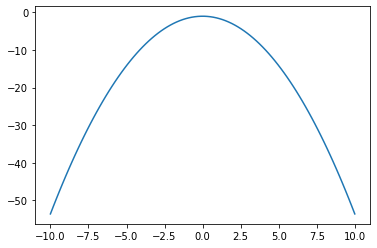

In [129]:
xr = np.linspace(-10, 10, 100)
plt.figure()
plt.plot(xr, [log_prob([x]) for x in xr])

In [111]:
def metropolis_hastings(log_prob, proposal_cov, iters, init):
    """Metropolis-Hastings
    """
    dim = proposal_cov.shape[0]
    
    samples = np.empty((iters, dim))
    samples[0] = init
    current_log_prob = log_prob(init)
    
    proposals = np.random.multivariate_normal(
        np.zeros(dim), proposal_cov, size=iters-1)
    
    log_unifs = np.log(np.random.rand(iters-1))
    
    for idx, (sample, log_unif) in enumerate(zip(proposals, log_unifs), start=1):
        proposal = sample + samples[idx-1]
        proposal_log_prob = log_prob(proposal)
        # accept is False (zero) or True (one)
        accept = (log_unif < proposal_log_prob - current_log_prob)
        
        if accept:
            samples[idx] = proposal
        else:
            samples[idx] = samples[idx-1]
        
        # I don't understand this [accept] logic...
        # must be to get around using an if statement
#         samples[idx] = samples[idx-1]
#         samples[idx][accept] = proposal[accept]
        current_log_prob = proposal_log_prob
        
    return samples
    

In [112]:
samples = metropolis_hastings(log_prob, cov, 100000, [0,0])

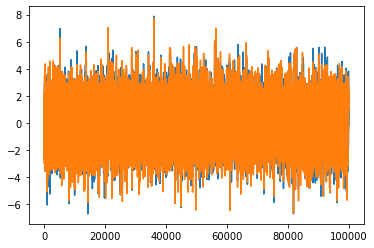

In [113]:
plt.figure()
plt.plot(range(samples.shape[0]), samples[:,0])
plt.plot(range(samples.shape[0]), samples[:,1])

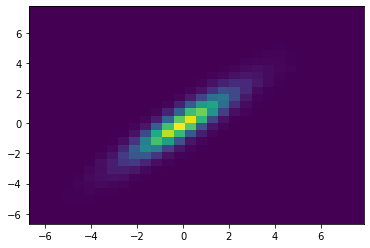

In [114]:
plt.figure()
plt.hist2d(samples[:,0], samples[:,1], bins=30);

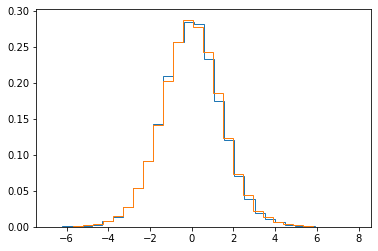

In [115]:
plt.figure()
plt.hist(samples[:,0], histtype='step', bins=30, density=True);
plt.hist(samples[:,1], histtype='step', bins=30, density=True);

# copied vectorised version

## i don't understand the [accept] indexing...

In [1]:
import numpy as np

def metropolis_hastings_vec(log_prob, proposal_cov, iters, chains, init):
    """Vectorized Metropolis-Hastings.

    Allows pretty ridiculous scaling across chains:
    Runs 1,000 chains of 1,000 iterations each on a
    correlated 100D normal in ~5 seconds.
    """
    proposal_cov = np.atleast_2d(proposal_cov)
    dim = proposal_cov.shape[0]
    # Initialize with a single point, or an array of shape (chains, dim)
    if init.shape == (dim,):
        init = np.tile(init, (chains, 1))

    samples = np.empty((iters, chains, dim))
    samples[0] = init
    current_log_prob = log_prob(init)

    proposals = np.random.multivariate_normal(np.zeros(dim), proposal_cov,
                                              size=(iters - 1, chains))
    log_unifs = np.log(np.random.rand(iters - 1, chains))
    for idx, (sample, log_unif) in enumerate(zip(proposals, log_unifs), 1):
        proposal = sample + samples[idx - 1]
        proposal_log_prob = log_prob(proposal)
        accept = (log_unif < proposal_log_prob - current_log_prob)

        # copy previous row, update accepted indexes
        samples[idx] = samples[idx - 1]
        samples[idx][accept] = proposal[accept]

        # update log probability
        current_log_prob[accept] = proposal_log_prob[accept]
    return samples

In [42]:
import scipy.stats as st

dim = 3
Σ = 0.1 * np.eye(dim) + 0.9 * np.ones((dim, dim))

# Correlated Gaussian
log_prob = st.multivariate_normal(np.zeros(dim),  Σ).logpdf

proposal_cov = np.eye(dim)
iters = 2_0000
chains= 1_024
init = np.zeros(dim)



In [43]:
%%time
samples = metropolis_hastings_vec(log_prob, proposal_cov, iters, chains, init)

CPU times: user 950 ms, sys: 39.1 ms, total: 989 ms
Wall time: 388 ms


In [44]:
samples.shape

(2000, 1024, 3)

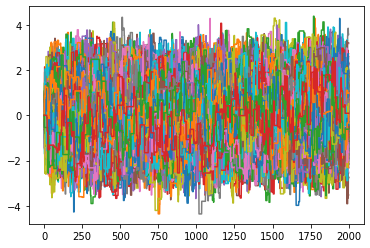

In [49]:
plt.figure()
plt.plot(samples[:,:,0]);

## figuring out [accept] notation

In [58]:
current_lp = log_prob([1,2,3])

In [61]:
type(current_lp)

numpy.float64

In [65]:
accept = True

In [66]:
int(accept)

1

In [67]:
current_lp[accept]

array([-13.11189736])

In [68]:
accept = False

In [69]:
int(accept)

0

In [70]:
current_lp[accept]

array([], dtype=float64)

In [78]:
current_lp

-13.111897358067694

In [119]:
def what_happens_when(accept):
    """accept = True or False
    """
    # current and proposed need to be numpy arrays for bool indexing
    current = np.array(1234)
    proposed = np.array(5678)
    
    print(f"current = {current}")
    print(f"proposed = {proposed}")
    
    print(f"current[accept] = {current[accept]}")
    print(f"proposed[accept] = {proposed[accept]}")
    current[accept] = proposed[accept]
    print(current)
    
    print(f"if accept is {accept}:")
    if accept:
        print("\t the proposed point is accepted")
    else:
        print("\t the current point is kept")


In [120]:
what_happens_when(accept=True)

current = 1234
proposed = 5678
current[accept] = [1234]
proposed[accept] = [5678]
5678
if accept is True:
	 the proposed point is accepted


In [121]:
what_happens_when(accept=False)

current = 1234
proposed = 5678
current[accept] = []
proposed[accept] = []
1234
if accept is False:
	 the current point is kept
